In [182]:
import string
from typing import Literal
import torch
from torch import nn
from einops import rearrange, reduce, einsum
from torch.nn import functional as F  # noqa: F401

class Forward(nn.Module):
    def __init__(
            self, 
            beta_t: torch.Tensor | float, 
            K: int, 
            T: int, 
            pad_id: int,
            noise_type: Literal["uniform", "absorbing"] = "uniform",
            absorbing_id: int = None
        ):
        assert noise_type == "uniform" or (noise_type == "absorbing" and absorbing_id is not None)
        super().__init__()
        if isinstance(beta_t, float):
            beta_t = torch.tensor([beta_t]).expand(T)
        else:
            assert len(beta_t) == T
            beta_t = beta_t
        
        self.steps = T
        self.K = K
        self.noise_type = noise_type
        self.absorbing_id = absorbing_id
        self.pad_id = pad_id

        self.register_buffer("beta_t_tensors", beta_t)
        self.register_buffer("one_minus_beta_t_cum_tensors", self._init_one_minut_beta_cum())

        self.register_buffer("qtcum_tensors", self._init_qtcum())
        self.register_buffer("qt_tensors", self._init_qt())

    def apply_qtcum(self, x: torch.Tensor, t: int=1) -> torch.Tensor:
        torch.manual_seed(0)
        return Forward.batch_sample_multinomial(self.qtcum_tensors[t][x])
    
    @staticmethod
    def batch_sample_multinomial(dists: torch.Tensor) -> torch.Tensor:
        samples = torch.multinomial(dists.view(-1, dists.shape[-1]), 1)
        return samples.view(dists.shape[:-1])

    def _init_one_minut_beta_cum(self) -> torch.Tensor:
        return torch.cumprod(1 - self.beta_t_tensors, dim=0)[:, None, None]
    
    def _init_qtcum(self) -> torch.Tensor:
        device = self.one_minus_beta_t_cum_tensors.device

        if self.noise_type == "uniform":
            qtcum = self.one_minus_beta_t_cum_tensors * torch.eye(self.K, device=device) + \
                    (1-self.one_minus_beta_t_cum_tensors) * torch.ones(self.K, self.K, device=device) / self.K
        elif self.noise_type == "absorbing":
            qtcum = self.one_minus_beta_t_cum_tensors * torch.eye(self.K, device=device) + \
                    (1-self.one_minus_beta_t_cum_tensors) * torch.ones(self.K, device=device)[:, None] @ \
                    torch.nn.functional.one_hot(torch.tensor([self.absorbing_id], device=device), num_classes=self.K).float()
        
        qtcum[:, :, self.pad_id] = 0
        qtcum[:, self.pad_id, :] = 0
        qtcum[:, self.pad_id, self.pad_id] = 1
        qtcum = qtcum / qtcum.sum(dim=-1, keepdim=True)
        return qtcum

    def _init_qt(self) -> torch.Tensor:
        device = self.beta_t_tensors.device
        beta_expanded = self.beta_t_tensors[:, None, None]
        
        if self.noise_type == "uniform":
            qt = (1-beta_expanded) * torch.eye(self.K, device=device) + \
                 beta_expanded * torch.ones(self.K, self.K, device=device) / self.K
        elif self.noise_type == "absorbing":
            qt = (1-beta_expanded) * torch.eye(self.K, device=device) + \
                 beta_expanded * torch.ones(self.K, device=device)[:, None] @ \
                 torch.nn.functional.one_hot(torch.tensor([self.absorbing_id], device=device), num_classes=self.K).float()
        
        qt[:, :, self.pad_id] = 0
        qt[:, self.pad_id, :] = 0
        qt[:, self.pad_id, self.pad_id] = 1
        qt = qt / qt.sum(dim=-1, keepdim=True)
        return qt

    def qt(self, x: torch.Tensor, t: int) -> torch.Tensor:
            device = self.beta_t_tensors.device

            if self.noise_type == "uniform":
                qt = (1 - self.beta_t_tensors[t]) * torch.eye(self.K, device=device) + \
                    self.beta_t_tensors[t] * torch.ones(self.K, self.K, device=device) / self.K
                    
            elif self.noise_type == "absorbing":
                absorb_idx = torch.tensor([self.absorbing_id], device=device)
                
                absorb_mat = torch.ones(self.K, device=device)[:, None] @ \
                            torch.nn.functional.one_hot(absorb_idx, num_classes=self.K).to(torch.float)

                qt = (1 - self.beta_t_tensors[t]) * torch.eye(self.K, device=device) + \
                    self.beta_t_tensors[t] * absorb_mat

            qt[:, self.pad_id] = 0
            qt[self.pad_id, :] = 0
            qt[self.pad_id, self.pad_id] = 1
            qt = qt / qt.sum(dim=-1, keepdim=True)
            
            return self.batch_sample_multinomial(qt[x])

class Tokenizer:
    def __init__(self, vocab: list=string.printable, max_len=10):
        self.id_to_tok = {i: tok for i, tok in enumerate(vocab)}
        self.dict = vocab
        self.size = len(vocab)
        self.max_len = max_len

        self.pad_token = "<PAD>"
        self.pad_id = self.size + 1
        self.id_to_tok[self.pad_id] = self.pad_token

        self.mask_token = "<MASK>"
        self.mask_id = self.size
        self.id_to_tok[self.mask_id] = self.mask_token

        self.tok_to_id = {tok: i for i, tok in self.id_to_tok.items()}

    def encode(
            self, 
            texts: list[str], 
            device: torch.device = "cpu", 
            padding_strategy: Literal["max_len", "longest"] = "max_len"
        ) -> torch.Tensor:
        max_len = self.max_len if padding_strategy == "max_len" else max([len(text) for text in texts])

        batch_ids = []
        for text in texts:
            ids = [self.tok_to_id[tok] for tok in text][:max_len]
            batch_ids.append(ids + (max_len-len(ids)) * [self.pad_id])
        return torch.tensor(batch_ids, dtype=torch.long, device=device)
    
    def decode(self, x: torch.Tensor) -> str:
        decoded_batch = []
        for seq in x:
            decoded_batch.append("".join([self.id_to_tok[i.item()] for i in seq if i.item() != self.pad_id]))
        return decoded_batch

# maybe nicer if forward needed tokenizer to avoid vocab size mistakes
# I skip the padding token from K, add mask
forward = Forward(beta_t=0.03, K=len(string.printable)+2, T=50, noise_type="absorbing", absorbing_id=len(string.printable), pad_id=len(string.printable)+1)
tokenizer = Tokenizer(string.printable)

x = tokenizer.encode(["hello", "bye"])
print("Encoded:", x)
print("Decoded:", tokenizer.decode(x))

breakpoint()

xhat = torch.clone(x)
for i in range(50):
    xhat = forward.qt(x=xhat, t=i)
    print(tokenizer.decode(xhat))

# xt = forward.apply_qtcum(x0, t)
# x0pred = model(xt)
# 
# Lvb := Dkl[q(xt-1 | xt, x0) || p(xt-1 | xt)]
# p(xt-1 | xt) = sum_x'0 (q(xt, xt-1 | x'0) * p(x'0 | xt)) / q(xt | x'0)

# q: [T, K, K]
#
# q(xt, xt-1 | x'0) = q(xt | xt-1, x'0) * q(xt-1 | x'0) =(Markov)= q(xt | xt-1) * q(xt-1 | x'0)
# when calculating loss:
# q(xt | xt-1) = qt[t, :, xt_id] [K]
# (explicit sum) q(xt-1 | x'0) = qtcum[t-1, x'0_id, :] [K]
# (implicit sum) q(xt-1 | x'0) = qtcum[t-1, :, :] [K, K]
#
# q(xt-1|xt, x0) = [q(xt | xt-1) * q(xt-1 | x0)] / q(xt | x0)
# q(xt-1|xt, x0) = qt[t, :, xt_id] * qtcum[t-1, x0_id, :] / qtcum[t, x0_id, xt_id]

# sample x0 -> x0
# sample t -> t
# apply t to x0 -> xt
# pass xt to model -> pred

def loss(t, x0, xt, pred, pad_id, forward):
    # auxiliary (direct model to x0) loss
    lax = F.cross_entropy(pred.transpose(0, 1), x0, ignore_index=pad_id)

    # NVLB (trajectory, t to t-1) loss
    qt = forward.qt_tensors
    qtcum = forward.qtcum_tensors
    probs = F.softmax(pred, dim=-1)
    # weight x0: x_t-1 by corresponding model prediction of x0
    # "based on model prediction, onto which t-1 token distribution I land with what probability"
    qp_sum = probs @ qtcum[t-1]
    # probs: [1, K] (Row vector)
    # qtcum: [K, K] (Matrix)
    # weigh tokens by the probability of landing on correct xt
    constraint = qt[t, :, xt]
    p_prev = qp_sum * constraint
    p_prev /= p_prev.sum() + 1e-8

    q_prev_cond = qt[t, :, xt] * qtcum[t-1, x0, :]
    q_prev_cond /= q_prev_cond.sum() + 1e-8

    lvb = F.kl_div(input=p_prev.log(), target=q_prev_cond, reduce=None)

    return lax + lvb

Encoded: tensor([[ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101],
        [ 11,  34,  14, 101, 101, 101, 101, 101, 101, 101]])
Decoded: ['hello', 'bye']
['h<MASK>ll<MASK>', 'bye']
['h<MASK>ll<MASK>', 'bye']
['h<MASK>ll<MASK>', 'bye']
['h<MASK>ll<MASK>', 'by<MASK>']
['h<MASK>ll<MASK>', 'by<MASK>']
['h<MASK>ll<MASK>', 'by<MASK>']
['h<MASK>ll<MASK>', 'by<MASK>']
['h<MASK>ll<MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'by<MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h<MASK>l<MASK><MASK>', 'b<MASK><MASK>']
['h

In [183]:
torch.manual_seed(0)
preds = torch.rand(10, 102)
preds

tensor([[0.4963, 0.7682, 0.0885,  ..., 0.2121, 0.9704, 0.8369],
        [0.2820, 0.3742, 0.0237,  ..., 0.8223, 0.1220, 0.1567],
        [0.2097, 0.8500, 0.3203,  ..., 0.6152, 0.5982, 0.1288],
        ...,
        [0.9883, 0.3753, 0.5250,  ..., 0.1523, 0.5825, 0.7164],
        [0.3030, 0.9153, 0.4671,  ..., 0.6821, 0.0615, 0.1371],
        [0.7204, 0.5681, 0.7438,  ..., 0.4635, 0.2107, 0.6437]])

## Single Token

In [455]:
x0 = x[0][0]
t = 1
xt = forward.apply_qtcum(x0, t)
pred = torch.zeros(102)
pred[100] = 100

pad_id = forward.pad_id
print("x0:", x0)
print("xt:", xt)
print("pred max prob:", F.softmax(pred).max(dim=0))
print("tokenizer mask id:", tokenizer.mask_id)

x0: tensor(17)
xt: tensor(17)
pred max prob: torch.return_types.max(
values=tensor(1.),
indices=tensor(100))
tokenizer mask id: 100


/var/folders/sv/w7ktc7zj5z599_rcq8wsnttw0000gn/T/ipykernel_61792/728041552.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("pred max prob:", F.softmax(pred).max(dim=0))


[tensor(18.4207), tensor(18.4207), tensor(18.4207), tensor(0.4858), tensor(0.3526), tensor(0.2659), tensor(0.2057), tensor(0.1622)]
tensor([0.1670, 0.2847, 0.3857, 0.4725, 0.5470, 0.6110, 0.6660, 0.7132])
[tensor(0.1806), tensor(0.1806), tensor(0.1806), tensor(0.0048), tensor(0.0035), tensor(0.0026), tensor(0.0020), tensor(0.0016)]


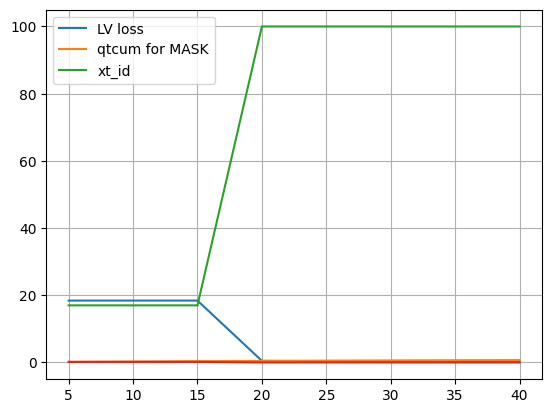

In [456]:
import matplotlib.pyplot as plt

lvbs = []
lvbs_og = []
xts = []
for t in [5, 10, 15, 20, 25, 30, 35, 40]:
    xt = forward.apply_qtcum(x0, t)
    xts.append(xt)
    lax = F.cross_entropy(pred, x0, ignore_index=pad_id)

    # NVLB (trajectory, t to t-1) loss
    qt = forward.qt_tensors
    qtcum = forward.qtcum_tensors
    probs = F.softmax(pred, dim=-1)
    # weight x0: x_t-1 by corresponding model prediction of x0
    # "based on model prediction, onto which t-1 token distribution I land with what probability"
    qp_sum = probs @ qtcum[t-1]
    # probs: [1, K] (Row vector)
    # qtcum: [K, K] (Matrix)
    # weigh tokens by the probability of landing on correct xt
    constraint = qt[t, :, xt]
    p_prev = qp_sum * constraint
    p_prev = p_prev / (p_prev.sum() + 1e-8)


    q_prev_cond = qt[t, :, xt] * qtcum[t-1, x0, :]
    q_prev_cond = q_prev_cond / (q_prev_cond.sum() + 1e-8)

    # lvb = F.kl_div(input=p_prev.log(), target=q_prev_cond, reduction="batchmean")

    eps = 1e-8

    q = q_prev_cond.clamp_min(eps)
    p = p_prev.clamp_min(eps)

    log_q = q.log()
    log_p = p.log()

    # KL(q || p)
    lvb = (q * (log_q - log_p)).sum()

    lax, lvb
    lvbs.append(lvb)

    lvb = F.kl_div(input=(p_prev+1e-8).log(), target=q_prev_cond+1e-8)
    lvbs_og.append(lvb) # equal to manual not scaled by K=100, so og*100 ~= manual


plt.plot(lvbs)
plt.plot(forward.qtcum_tensors[[5, 10, 15, 20, 25, 30, 35, 40], 0, 100])
plt.plot(xts)
plt.plot(lvbs_og)
plt.legend(["LV loss", "qtcum for MASK", "xt_id"])
plt.xticks(ticks=[i for i in range(8)], labels=[5, 10, 15, 20, 25, 30, 35, 40])
plt.grid()

print(lvbs)
print(forward.qtcum_tensors[[5, 10, 15, 20, 25, 30, 35, 40], 0, 100])
print(lvbs_og)

## Sequence

In [457]:
x0 = x[0]
t = 1
xt = forward.apply_qtcum(x0, t)
pred = torch.zeros(x0.shape[0], 102)
pred[:, 100] = 100
pred[x0 == 101, 100] = 0 
pred[x0 == 101, 101] = 100

pad_id = forward.pad_id
print("x0:", x0, x0.shape)
print("xt:", xt)
print("pred max prob:", F.softmax(pred, dim=-1).max(dim=1))
print("tokenizer mask id:", tokenizer.mask_id)
print("pred:", pred.shape)

x0: tensor([ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101]) torch.Size([10])
xt: tensor([ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101])
pred max prob: torch.return_types.max(
values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
indices=tensor([100, 100, 100, 100, 100, 101, 101, 101, 101, 101]))
tokenizer mask id: 100
pred: torch.Size([10, 102])


/Users/mikolajboronski/github/diffusion/.venv/lib/python3.12/site-packages/torch/nn/functional.py:3355: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


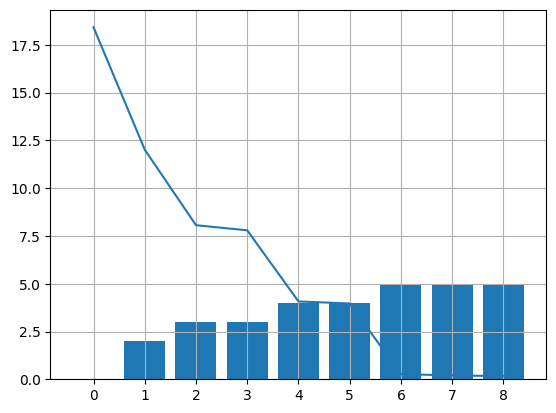

In [ ]:

lvbs = []
mask_count = []
for t in range(0, 45, 5):
    lax = F.cross_entropy(pred, x0, ignore_index=pad_id)

    xt = forward.apply_qtcum(x0, t)
    # NVLB (trajectory, t to t-1) loss
    qt = forward.qt_tensors
    qtcum = forward.qtcum_tensors
    probs = F.softmax(pred, dim=-1)
    # weight x0: x_t-1 by corresponding model prediction of x0
    # "based on model prediction, onto which t-1 token distribution I land with what probability"
    qp_sum = probs @ qtcum[t-1]
    # probs: [1, K] (Row vector)
    # qtcum: [K, K] (Matrix)
    # weigh tokens by the probability of landing on correct xt
    constraint = qt[t, :, xt]
    p_prev = qp_sum * constraint.T
    p_prev /= (p_prev.sum(dim=1, keepdim=True) + 1e-8)

    q_prev_cond = qt[t, :, xt].T * qtcum[t-1, x0, :]
    q_prev_cond /= (q_prev_cond.sum(dim=1, keepdim=True) + 1e-8)

    pad_mask = (x0 != pad_id)
    p_prev = p_prev[pad_mask].clamp_min(1e-8)
    q_prev_cond = q_prev_cond[pad_mask].clamp_min(1e-8)
    lvb = F.kl_div(input=p_prev.log(), target=q_prev_cond) * pred.shape[-1]
    lvbs.append(lvb)
    mask_count.append((xt == 100).sum())

plt.plot([i for i in range(9)], lvbs)
plt.bar([i for i in range(9)], mask_count)
plt.grid()
plt.xticks([i for i in range(9)])
plt.show()

## Batch

In [486]:
pred.shape, x0.shape

(torch.Size([2, 10, 102]), torch.Size([2, 10]))

In [ ]:
x0 = x
t = 1
xt = forward.apply_qtcum(x0, t)
pred = torch.zeros(x0.shape[0], x0.shape[1], 102)
pred[:, :, 100] = 100
pred[x0 == 101, 100] = 0 
pred[x0 == 101, 101] = 100

pad_id = forward.pad_id
print("x0:", x0, x0.shape)
print("xt:", xt)
print("pred max prob:", F.softmax(pred, dim=-1).max(dim=-1))
print("tokenizer mask id:", tokenizer.mask_id)
print("pred:", pred.shape)

x0: tensor([[ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101],
        [ 11,  34,  14, 101, 101, 101, 101, 101, 101, 101]]) torch.Size([2, 10])
xt: tensor([[ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101],
        [ 11,  34,  14, 101, 101, 101, 101, 101, 101, 101]])
pred max prob: torch.return_types.max(
values=tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
indices=tensor([[100, 100, 100, 100, 100, 101, 101, 101, 101, 101],
        [100, 100, 100, 101, 101, 101, 101, 101, 101, 101]]))
tokenizer mask id: 100
pred: torch.Size([2, 10, 102])


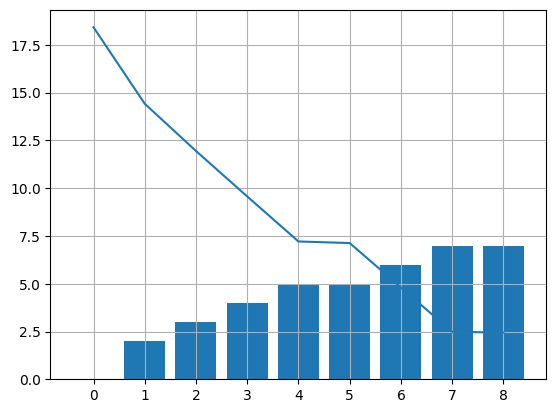

In [497]:

lvbs = []
mask_count = []
for t in range(0, 45, 5):
    lax = F.cross_entropy(pred.flatten(0, 1), x0.flatten(0, 1), ignore_index=pad_id)

    B, L, K = pred.shape
    xt = forward.apply_qtcum(x0, t)
    # NVLB (trajectory, t to t-1) loss
    qt = forward.qt_tensors
    qtcum = forward.qtcum_tensors
    probs = F.softmax(pred, dim=-1)
    # weight x0: x_t-1 by corresponding model prediction of x0
    # "based on model prediction, onto which t-1 token distribution I land with what probability"
    qp_sum = probs @ qtcum[t-1]
    # probs: [1, K] (Row vector)
    # qtcum: [K, K] (Matrix)
    # weigh tokens by the probability of landing on correct xt
    constraint = qt[t, :, xt.reshape(-1)].T.reshape(B, L, K)
    p_prev = qp_sum * constraint
    p_prev /= (p_prev.sum(dim=2, keepdim=True) + 1e-8)

    q_prev_cond = qt[t, :, xt.reshape(-1)].T.reshape(B, L, K) * qtcum[t-1, x0, :]
    q_prev_cond /= (q_prev_cond.sum(dim=2, keepdim=True) + 1e-8)

    pad_mask = (x0 != pad_id)
    p_prev = p_prev.clamp_min(1e-8)[pad_mask]
    q_prev_cond = q_prev_cond.clamp_min(1e-8)[pad_mask]
    lvb = F.kl_div(input=p_prev.log(), target=q_prev_cond, reduction="batchmean")
    lvbs.append(lvb)
    mask_count.append((xt == 100).sum())

plt.plot([i for i in range(9)], lvbs)
plt.bar([i for i in range(9)], mask_count)
plt.grid()
plt.xticks([i for i in range(9)])
plt.show()

In [505]:
x0

tensor([[ 17,  14,  21,  21,  24, 101, 101, 101, 101, 101],
        [ 11,  34,  14, 101, 101, 101, 101, 101, 101, 101]])

In [525]:
forward.qtcum_tensors[torch.randint(0, forward.steps, size=(2,))]

tensor([[[0.5606, 0.0000, 0.0000,  ..., 0.0000, 0.4394, 0.0000],
         [0.0000, 0.5606, 0.0000,  ..., 0.0000, 0.4394, 0.0000],
         [0.0000, 0.0000, 0.5606,  ..., 0.0000, 0.4394, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.5606, 0.4394, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],

        [[0.3550, 0.0000, 0.0000,  ..., 0.0000, 0.6450, 0.0000],
         [0.0000, 0.3550, 0.0000,  ..., 0.0000, 0.6450, 0.0000],
         [0.0000, 0.0000, 0.3550,  ..., 0.0000, 0.6450, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3550, 0.6450, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]]])

In [538]:
forward.qtcum_tensors[torch.randint(0, forward.steps, size=(2,))][:, x]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7537, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1920, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1920, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [539]:
Forward.batch_sample_multinomial(forward.qtcum_tensors[torch.randint(0, forward.steps, size=(2,))][:, x])

tensor([[[100, 100, 100, 100,  24, 101, 101, 101, 101, 101],
         [100,  34, 100, 101, 101, 101, 101, 101, 101, 101]],

        [[ 17, 100, 100, 100,  24, 101, 101, 101, 101, 101],
         [100, 100, 100, 101, 101, 101, 101, 101, 101, 101]]])